# Exercises for the 3rd March 2021

Kim Antunez

In [1]:
#import libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import collections
from scipy.optimize import curve_fit
import pandas as pd
import random
from statistics import mean

random.seed(1) #to always obtain the same results

# 1. Comparaison de deux réseaux de collaboration (astrophysique et physique des hautes énergies)

Analyser et comparer deux **réseaux de collaboration** : 

1. en astrophysique **AP** (CA-AstroPh.txt)
2. en physique des hautes énergies **PHE** (CA-HepPh.txt)

Dans une réseau de collaboration, les noeuds représentent les **chercheurs d’une discipline**, et il sont connectés par un lien s’ils sont **co-auteurs** d’un ou plus papiers.  Les deux bases de données sont extraites de l’archive de pre-prints ArXiv. 


L'analyse des deux réseaux peut reprendre les éléments de l'**exercice 2** fait en classe. 
- le nombre de noeuds et de liens
- composantes.
- distribution du degré
- "*mixing*"
- ...

Il est aussi possible d'intégrer d'autres mesures intéressantes vues dans les TP précédents (diamètre par exemple). C'est un exercice assez libre. 

## Description of the network

In [2]:
#Read datasets
#Astrophysique
infile='data/CA-AstroPh.txt'
AP_DG=nx.read_edgelist(infile, delimiter='\t',create_using=nx.DiGraph())
#Physique hautes énergies
infile='data/CA-HepPh.txt'
PHE_DG=nx.read_edgelist(infile, delimiter='\t',create_using=nx.DiGraph())

In [3]:
#Number of nodes/number of edges
print ('Numbers of nodes and edges')
print ('AP_DG',AP_DG.number_of_nodes(),AP_DG.number_of_edges())
print ('PHE_DG',PHE_DG.number_of_nodes(),PHE_DG.number_of_edges())

Numbers of nodes and edges
AP_DG 18772 396160
PHE_DG 12008 237010


- Le **réseau dirigé** d'**Astrophysique** comporte 18 772 noeuds et 396 160 liens. 
- Le **réseau dirigé** de **Physique des hautes énergies** comporte 12 008 noeuds et 237 010 liens. 

Mais est-il vraiment pertinent de considérer ce graphe comme non dirigé ? Pour répondre à cette question, nous allons analyser la **réciprocité des liens**. 

In [4]:
print ('Reciprocity')
print('AP_DG', nx.reciprocity(AP_DG))
print('PHE_DG', nx.reciprocity(PHE_DG))

Reciprocity
AP_DG 0.9998485460420032
PHE_DG 0.9998649845998059


Pour les deux graphes, la réciprocité est **proche de 100 %**. 

Cela s'explique par la manière dont sont comptabilisés les liens entre auteurs et co-auteurs, décrite dans la documentation :  
"*An author $i$ co-authored a paper with author $j$, the graph contains a undirected edge from $i$ to $j$. If the paper is co-authored by $k$ authors this generates a completely connected (sub)graph on $k$ nodes.*"

Il nous semble alors plus pertinent de considérer **des graphes non dirigés** pour notre analyse dans cette partie. 

In [5]:
# Create undirected graphs
AP = nx.DiGraph.to_undirected(AP_DG)
PHE = nx.DiGraph.to_undirected(PHE_DG)

- Le **réseau non dirigé** d'**Astrophysique** comporte 18 772 noeuds et 198 110 liens (près de deux fois moins qu'avant) 
- Le **réseau non dirigé** de **Physique des hautes énergies** comporte 12 008 noeuds et 118 521 liens (près de deux fois moins qu'avant) 

In [6]:
#Number of nodes/number of edges
print ('Numbers of nodes and edges')
print ('AP',AP_DG.number_of_nodes(),AP.number_of_edges())
print ('PHE',PHE_DG.number_of_nodes(),PHE.number_of_edges())

Numbers of nodes and edges
AP 18772 198110
PHE 12008 118521


La densité de ces graphes est relativement faible. Le réseau PHE est légèrement plus dense bien que comportant moins de noeuds et d'arêtes. 

In [7]:
#network density
print ('Density')
print ('AP', nx.density(AP))
print ('PHE', nx.density(PHE))

Density
AP 0.0011244455715955115
PHE 0.0016440692740471677


Les deux graphes **ne comportent pas de noeuds isolés**. Toutefois, ils ne sont **pas** pour autant **connectés**. 

Il existe donc des **sous-réseaux d'auteurs indépendants**.

In [8]:
#is connected?
print ('Is graphe connected ?')
print("AP : ",nx.is_connected(AP))
print("PHE : ",nx.is_connected(PHE))

Is graphe connected ?
AP :  False
PHE :  False


In [9]:
# find isolates (components consisting in 1 node)
print ('List of isolates')
print("AP : ",list(nx.isolates(AP)))
print("PHE : ",list(nx.isolates(PHE)))

List of isolates
AP :  []
PHE :  []


Les cliques sont très nombreux dans les deux réseaux. Il existe donc de nombreux sous-graphes très connectés d'auteurs qui écrivent les uns avec les autres dans les deux disciplines. La taille moyenne de ces cliques est d'environ 6 ou 7. 

In [10]:
### find cliques 
cliques = list(nx.find_cliques(AP))
print("Nombre de cliques AP : ", len(cliques))
print("Longueur moyenne des cliques AP : ", mean([len(col) for col in cliques]))

cliques = list(nx.find_cliques(PHE))
print("Nombre de cliques PHE : ", len(cliques))
print("Longueur moyenne des cliques PHE : ", mean([len(col) for col in cliques]))

Nombre de cliques AP :  36428
Longueur moyenne des cliques AP :  6.872103876139233
Nombre de cliques PHE :  14939
Longueur moyenne des cliques PHE :  6.168819867461008


La transitivité est de 32 % pour le réseau AP et de 66 % pour le réseau PHE, soit 2 fois plus importante, ce qui peut vouloir dire que les relations entre auteurs sont plus courantes en physiques des hautes énergies. 

In [11]:
##### Transitivity : this is the global clustering coefficient
print("Transitivity")
print("AP", nx.transitivity(AP))  
print("PHE", nx.transitivity(PHE)) 

Transitivity
AP 0.3180015812533629
PHE 0.6594770091473294


**Rappel** : Le coefficient de groupement local (*local clustering coefficient*) mesure la cohésion dans le voisinage d'un noeud (combien de ses amis sont amis entre eux). Pour chaque noeud $i$,
$$
CI_i=\frac{\text{number existing ties between i's friends}}{\text{number possible ties between i's friends}}
$$

L'*average of local clustering coefficient* est proche pour les 2 réseaux : **63 % pour AP et 61 % pour PHE**. 

In [12]:
## take the average of local clustering coefficient
print("Average of local clustering coefficient")
print("AP", nx.average_clustering(AP)) 
print("PHE", nx.average_clustering(PHE)) 

Average of local clustering coefficient
AP 0.6305932411707943
PHE 0.6114825236824339


Comme les graphes ne sont pas connectés, **certaines indicateurs ne pourront pas être calculés**, comme par exemple le **diamètre** ou **l'average shortest path length** (cf. ci-dessous).

In [13]:
## diameter
# because graph is not strongly connected (infinite distances)
# we need to take its undirected representation
#print(nx.diameter(ELfriendUG))
def calculer_diametre(G):
    if nx.is_directed(G):
        if not nx.is_weakly_connected(G):
            print("Calcul du diamètre impossible car le graphe n'est pas connecté.")
        else:
            UG = nx.DiGraph.to_undirected(G)
            print("Diamètre :",nx.diameter(UG))   
    else:
        if not nx.is_connected(G):
            print("Calcul du diamètre impossible car le graphe n'est pas connecté.")
        else:
            UG = G.copy()   
            print("Diamètre :",nx.diameter(UG))

print("AP")
calculer_diametre(AP)
print("PHE")
calculer_diametre(PHE)


## average shortest path length
def calculer_shortest_path_length(G):
    if nx.is_directed(G):
        if not nx.is_weakly_connected(G):
            print("Calcul du chemin le plus court impossible car le graphe n'est pas connecté.")
        else:
            UG = nx.DiGraph.to_undirected(G)
            print("Longueur du chemin le plus court :",nx.average_shortest_path_length(UG))   
    else:
        if not nx.is_connected(G):
             print("Calcul du chemin le plus court impossible car le graphe n'est pas connecté.")
        else:
            UG = G.copy()   
            print("Longueur du chemin le plus court :",nx.average_shortest_path_length(UG))


print("AP")
calculer_shortest_path_length(AP)
print("PHE")
calculer_shortest_path_length(PHE)

AP
Calcul du diamètre impossible car le graphe n'est pas connecté.
PHE
Calcul du diamètre impossible car le graphe n'est pas connecté.
AP
Calcul du chemin le plus court impossible car le graphe n'est pas connecté.
PHE
Calcul du chemin le plus court impossible car le graphe n'est pas connecté.


## Degree distribution visualization

Les deux réseaux ont un **degré moyen proche (autour de 20)** pour des valeurs minimales et maximales respectivement proches de 1 et 500. 

Ils se différencient toutefois par leur **écart-type qui est plus élevé pour PHE**. 


In [14]:
# Degree list
print("Degree distribution")
kkAP=[AP.degree(u) for u in AP.nodes()]
maxDegreeAP=max(kkAP)
minDegreeAP=min(kkAP)
averageDegreeAP=np.mean(kkAP)
stdDegreeAP=np.std(kkAP)
print ("AP", maxDegreeAP,minDegreeAP,averageDegreeAP,stdDegreeAP)

kkPHE=[PHE.degree(u) for u in PHE.nodes()]
maxDegreePHE=max(kkPHE)
minDegreePHE=min(kkPHE)
averageDegreePHE=np.mean(kkPHE)
stdDegreePHE=np.std(kkPHE)
print ("PHE", maxDegreePHE,minDegreePHE,averageDegreePHE,stdDegreePHE)


Degree distribution
AP 504 1 21.10696782441935 30.571341574526
PHE 491 1 19.740339773484344 46.63799734572869


### Plotting the degree distribution

Afin d'avoir une vision plus précise de la distribution des degrés, il est possible de tracer un **histogramme** mais ce graphique est difficile à analyser, c'est pourquoi nous devons passer à une **échelle logarithmique**. 

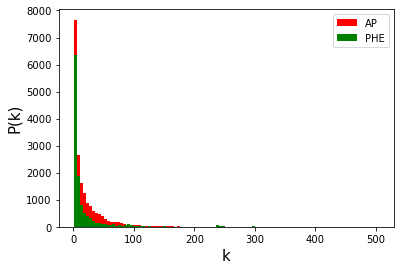

In [15]:
plt.hist(kkAP, bins = 100 ,label="AP", color="red")
plt.hist(kkPHE, bins = 100 ,label="PHE", color="green")
plt.xlabel('k',size=15)
plt.ylabel('P(k)',size=15)
plt.legend()
plt.show()

Le graphique à l'échelle logarithmique prend la forme d'une **droite décroissante**. 

Le point rouge tout à droite indique que la probabilité d'avoir un noeud de haut degré est plus faible pour AP que pour PHE. 

**Ce sont donc deux distributions assez équivalentes, sauf pour les noeuds à hauts degrés (auteurs ayant co-écrits avec beaucoup de personnes) qui sont plus rares en astrophysique qu'en physique des hautes énergies.**

In [16]:
# a function for log binning for distributions
def logBinning(degreeList,nbin):
    kmin=min(degreeList)
    kmax=max(degreeList)
    logBins = np.logspace(np.log10(kmin), np.log10(kmax),num=nbin)
    logBinDensity, binedges = np.histogram(degreeList, bins=logBins, density=True)
    logBins = np.delete(logBins, -1)
    return logBinDensity, logBins

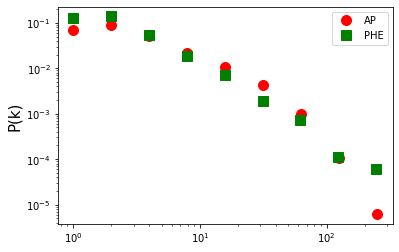

In [17]:
y,x=logBinning(np.array(kkAP),10)
plt.loglog(x,y,'o',label='AP',color='red',markersize=10)
y,x=logBinning(np.array(kkPHE),10)
plt.loglog(x,y,'s',label='PHE',color='green',markersize=10)
plt.ylabel('P(k)',size=15)
plt.legend()
plt.show()

## Clustering spectrum


On va faire des moyennes de clustering pour certaines classes de valeurs. 

- En bleu : tous les points. 
- En rouge/vert : la moyenne par classes de degrés (et non par degré k !)

In [18]:
ccAP=[nx.clustering(AP,u) for u in AP.nodes()]
ccPHE=[nx.clustering(PHE,u) for u in PHE.nodes()]

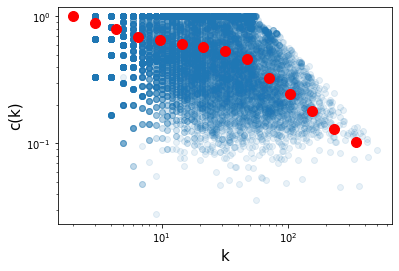

In [19]:
#Pour une discipline (Astro-physique)
xx=[u for (u,v) in zip(kkAP,ccAP) if v>0] #j'enlève les 0 car on ne peut pas faire log0
yy=[v for (u,v) in zip(kkAP,ccAP) if v>0]
plt.loglog(xx,yy,'o',alpha=0.1)
logBins=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',label='AP',markersize=10, color="red")

plt.xlabel('k',size=15)
plt.ylabel('c(k)',size=15)
plt.show()

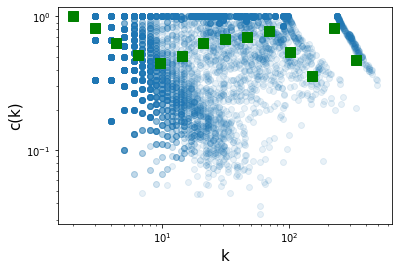

In [20]:
#Pour une discipline (Physique hautes énergies)
xx=[u for (u,v) in zip(kkPHE,ccPHE) if v>0] #j'enlève les 0 car on ne peut pas faire log0
yy=[v for (u,v) in zip(kkPHE,ccPHE) if v>0]
plt.loglog(xx,yy,'o',alpha=0.1)
logBins=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'s',label='AP',markersize=10, color="green")
plt.xlabel('k',size=15)
plt.ylabel('c(k)',size=15)
plt.show()

 - **Réseau AP** : Dans ce réseau la tendance est décroissante : les noeuds qui ont un degré plus élevé (ont le plus de lien de co-écriture) ont un niveau de clustering (nombre de ses relations en relations entre elles) plus bas. Les chercheurs qui co-écrivent le plus d'articles ont des co-auteurs qui ne sont pas forcément en relation. Ils sont donc peut-être dans une situation de "leaders". Les gens écrivent pour eux en raison de leur notoriété mais pas par réseau. 

- **Réseau PHE** : Dans ce réseau, l'effet précédent n'est pas observé. 


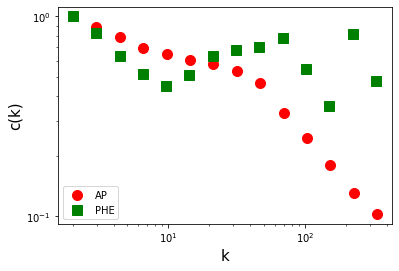

In [21]:
#Pour les deux disciplines
xx=[u for (u,v) in zip(kkAP,ccAP) if v>0] #j'enlève les 0 car on ne peut pas faire log0
yy=[v for (u,v) in zip(kkAP,ccAP) if v>0]
logBins=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',label='AP',markersize=10, color="red")

xx=[u for (u,v) in zip(kkPHE,ccPHE) if v>0]
yy=[v for (u,v) in zip(kkPHE,ccPHE) if v>0]
logBins=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'s',label='PHE',markersize=10, color="green")

plt.xlabel('k',size=15)
plt.ylabel('c(k)',size=15)
plt.legend()
plt.show()

## Degree mixing

Je choisis le noeud 3e noeud (numéro 1662). 

In [22]:
ego=list(AP.nodes())[2]

In [23]:
ego

'1662'

In [24]:
neighEgo=list(AP.neighbors(ego))

In [25]:
neighEgo

['84424',
 '3393',
 '6908',
 '10341',
 '11257',
 '11513',
 '24798',
 '26413',
 '30664',
 '30828',
 '32559',
 '33040',
 '36528',
 '38595',
 '43697',
 '52682',
 '53609',
 '54131',
 '54746',
 '54856',
 '56381',
 '56494',
 '59801',
 '61290',
 '76259',
 '77816',
 '86738',
 '87401',
 '88903',
 '92134',
 '97101',
 '104248',
 '106338',
 '110902',
 '117632',
 '117734',
 '121965',
 '122290',
 '124529',
 '127302',
 '128492',
 '128598',
 '131263']

In [26]:
degreeNeighEgo=[AP.degree(v) for v in neighEgo]

In [27]:
degreeNeighEgo

[75,
 27,
 96,
 133,
 118,
 136,
 62,
 61,
 71,
 93,
 37,
 257,
 102,
 26,
 21,
 281,
 5,
 91,
 138,
 105,
 27,
 98,
 51,
 174,
 47,
 119,
 53,
 37,
 64,
 5,
 22,
 8,
 10,
 172,
 26,
 98,
 18,
 6,
 224,
 12,
 18,
 76,
 26]

In [28]:
np.mean(degreeNeighEgo)

77.34883720930233

On fait un knn pour tous les noeuds et pour tout le réseau. 

In [29]:
knnAP=[ np.mean([AP.degree(v) for v in AP.neighbors(u)])  for u in AP.nodes()]
knnPHE=[np.mean([PHE.degree(v) for v in PHE.neighbors(u)]) for u in PHE.nodes()]

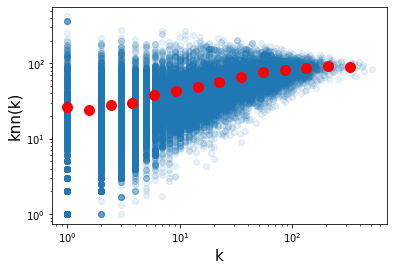

In [30]:
#Pour une discipline (Astrophysique)
xx=[u for (u,v) in zip(kkAP,knnAP) if v>0]
yy=[v for (u,v) in zip(kkAP,knnAP) if v>0]
plt.loglog(xx,yy,'o',alpha=0.1)
logBins=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
#if I use np.linspace I will have linear bins
ybin,xbin,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',label='AP',markersize=10, color="red")

plt.xlabel('k',size=15)
plt.ylabel('knn(k)',size=15)
plt.show()

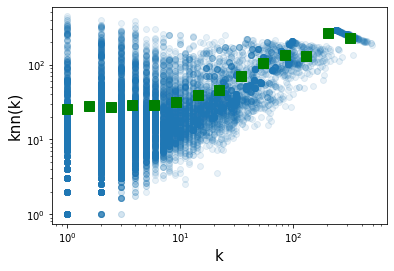

In [31]:
#Pour une discipline (Physique hautes énergies)
xx=[u for (u,v) in zip(kkPHE,knnPHE) if v>0]
yy=[v for (u,v) in zip(kkPHE,knnPHE) if v>0]
plt.loglog(xx,yy,'o',alpha=0.1)
logBins=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
#if I use np.linspace I will have linear bins
ybin,xbin,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'s',label='AP',markersize=10, color="green")

plt.xlabel('k',size=15)
plt.ylabel('knn(k)',size=15)
plt.show()

Pour les deux graphe, on observe une situation d'**assortative mixing** dans laquelle les noeuds de faibles degrés vont être liés à des noeuds de faibles degrés et ceux de forts degrés à des noeuds de forts degrés. Cela signifie que des chercheurs très connus vont collaborer plus facilement avec des chercheurs très connus alors que les chercheurs peu connus vont aussi s'associer entre eux. 

Cet effet assortatif est encore plus fort pour le réseau **PHE**.

Il faudrait connaître les différences de liens entre auteurs scientifiques entre les deux disciplines pour interpréter cela plus en profondeur. 

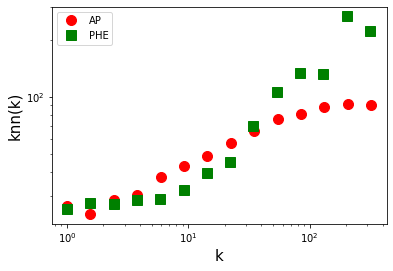

In [32]:
#Pour les deux disciplines
xx=[u for (u,v) in zip(kkAP,knnAP) if v>0]
yy=[v for (u,v) in zip(kkAP,knnAP) if v>0]
logBins=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
#if I use np.linspace I will have linear bins
ybin,xbin,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',label='AP',markersize=10, color="red")

xx=[u for (u,v) in zip(kkPHE,knnPHE) if v>0]
yy=[v for (u,v) in zip(kkPHE,knnPHE) if v>0]
logBins=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'s',label='PHE',markersize=10, color="green")

plt.xlabel('k',size=15)
plt.ylabel('knn(k)',size=15)
plt.legend()
plt.show()

# 2. Echanges commerciaux de bananes et voitures entre pays

Analyser et comparer la robustesse des réseaux des échanges commerciaux, entre pays, de **bananes** et de **voitures**. 

Au lieu de faire des attaques ciblées sur le degré, vous pouvez réaliser des **attaques ciblées sur la force des noeuds** pour voir ce qui se passe. 

Vous pouvez si vous le souhaitez travailler cette fois-ci sur les **graphes dirigés**. 

In [33]:
#import libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import collections
from scipy.optimize import curve_fit
import pandas as pd
import random

random.seed(1) #to always obtain the same results

In [34]:
dfB=pd.read_csv('data/bananasDB.csv',sep=',')
dfB = dfB.rename(columns={'v': 'weight'})
dfB.head()

,exp,imp,weight
0,Afghanistan,France,3.203
1,Albania,Greece,26.597
2,Andorra,Canada,0.116
3,Angola,France,0.100
4,Angola,Japan,0.018


In [35]:
dfV=pd.read_csv('data/vehiclesDB.csv',sep=',')
dfV = dfV.rename(columns={'v': 'weight'})
dfV.head()

,exp,imp,weight
0,Albania,France,8950.537
1,Albania,Greece,1487.509
2,Albania,Italy,14660.651
3,Albania,Senegal,1511.352
4,Algeria,Egypt,3411.627


In [36]:
# Graphes dirigés
dGB=nx.from_pandas_edgelist(dfB,'exp','imp',['weight'],create_using=nx.DiGraph())
dGV=nx.from_pandas_edgelist(dfV,'exp','imp',['weight'],create_using=nx.DiGraph())

In [37]:
# Si j'avais voulu passer en non dirigé (mais ici nous restons en dirigé) 
#GB=nx.to_undirected(dGB)
#for (i,j) in GB.edges():
#    GB[i][j]['weight']=0
#    if (i,j) in dGB.edges():
#        GB[i][j]['weight']+= dGB[i][j]['v'] #new
#        GB[j][i]['weight'] = GB[i][j]['weight'] #new
#    if (j,i) in dbananas.edges():
#        GB[i][j]['weight']+= dGB[j][i]['v'] #new
#        GB[j][i]['weight'] = GB[i][j]['weight'] #new

        
# Ici, je reste en dirigé
GB=dGB.copy()
GV=dGV.copy()

In [38]:
print("GB")
print(list(GB.edges(data=True))[:5])

print("GV")
print(list(GV.edges(data=True))[:5])

GB
[('Afghanistan', 'France', {'weight': 3.2030000000000003}), ('France', 'Algeria', {'weight': 206.48}), ('France', 'Antigua and Barbuda', {'weight': 0.109}), ('France', 'Austria', {'weight': 341.324}), ('France', 'Bahamas', {'weight': 0.333})]
GV
[('Albania', 'France', {'weight': 8950.537}), ('Albania', 'Greece', {'weight': 1487.509}), ('Albania', 'Italy', {'weight': 14660.651000000002}), ('Albania', 'Senegal', {'weight': 1511.3520000000005}), ('France', 'Albania', {'weight': 7280.185000000001})]


La densité du graphe de commerce de voitures est plus importante que celle du graphe de commerce de bananes.

In [39]:
print("Density")
print("GB", nx.density(GB))
print("GV", nx.density(GV))

Density
GB 0.04977320392137736
GV 0.11584285587740278


## Weight's distribution

Les échanges de voitures semblent être de plus grande ampleur que les échanges de bananes.

In [40]:
def logBinning(degreeList,nbin):
    kmin=min(degreeList)
    kmax=max(degreeList)
    logBins = np.logspace(np.log10(kmin), np.log10(kmax),num=nbin)
    logBinDensity, binedges = np.histogram(degreeList, bins=logBins,density=True)
    logBins = np.delete(logBins, -1)
    return logBinDensity, logBins

In [41]:
weightsB=[GB[u][v]['weight'] for (u,v) in GB.edges()]
weightsV=[GV[u][v]['weight'] for (u,v) in GV.edges()]

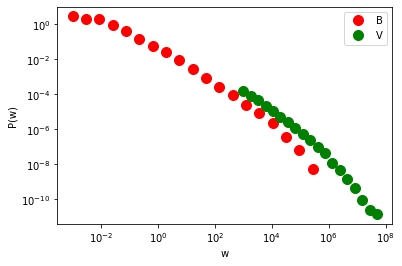

In [42]:
y,x=logBinning(np.array(weightsB),20)
plt.loglog(x,y,'o',markersize=10, color="red", label="B")
y,x=logBinning(np.array(weightsV),20)
plt.loglog(x,y,'o',markersize=10, color="green", label="V")
plt.xlabel('w')
plt.ylabel('P(w)')
plt.legend()
plt.show()

## Strength distribution

**Rappel** : La force d'un noeud est égale à la somme des poids des liens auxquels il est connecté :
$$
s_i=\sum_j w_{ij}
$$

Dans le cas d'un réseau dirigé comme celui-ci, on peut, dans la même logique que l'on peut définir des in-degrees et out-degrees, définir des in-strength et out-strength.

Comme précédemment, le réseau d'échanges de voiture semble contient des poids plus élevés que celui des bananes (en in, out, et total).

In [43]:
sB=list(dict(GB.degree(weight='weight')).values())
sB_in=list(dict(GB.in_degree(weight='weight')).values())
sB_in = [i for i in sB_in if i != 0] #new because  of in and out-degrees to remove 0's
sB_out=list(dict(GB.out_degree(weight='weight')).values())
sB_out = [i for i in sB_out if i != 0] #new because  of in and out-degrees to remove 0's
sV=list(dict(GV.degree(weight='weight')).values())
sV_in=list(dict(GV.in_degree(weight='weight')).values())
sV_in = [i for i in sV_in if i != 0] #new because  of in and out-degrees to remove 0's
sV_out=list(dict(GV.out_degree(weight='weight')).values())
sV_out = [i for i in sV_out if i != 0] #new because  of in and out-degrees to remove 0's

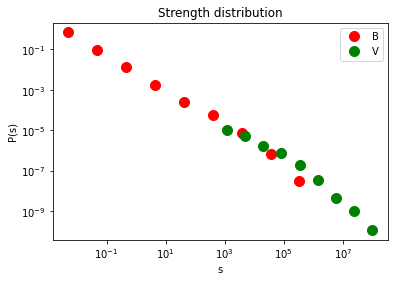

In [44]:
y,x=logBinning(np.array(sB),10)
plt.loglog(x,y,'o',markersize=10, color="red", label="B")
y,x=logBinning(np.array(sV),10)
plt.loglog(x,y,'o',markersize=10, color="green", label="V")
plt.xlabel('s')
plt.ylabel('P(s)')
plt.title("Strength distribution")
plt.legend()
plt.show()

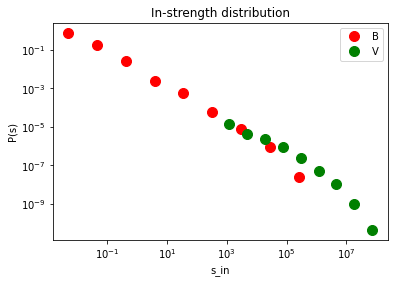

In [45]:
y,x=logBinning(np.array(sB_in),10)
plt.loglog(x,y,'o',markersize=10, color="red", label="B")
y,x=logBinning(np.array(sV_in),10)
plt.loglog(x,y,'o',markersize=10, color="green", label="V")
plt.xlabel('s_in')
plt.ylabel('P(s)')
plt.title("In-strength distribution")
plt.legend()
plt.show()

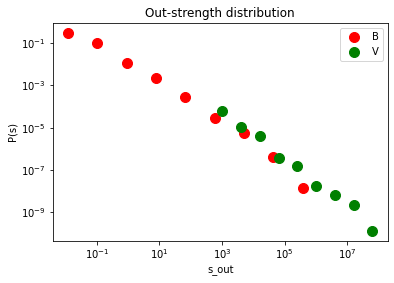

In [46]:
y,x=logBinning(np.array(sB_out),10)
plt.loglog(x,y,'o',markersize=10, color="red", label="B")
y,x=logBinning(np.array(sV_out),10)
plt.loglog(x,y,'o',markersize=10, color="green", label="V")
plt.xlabel('s_out')
plt.ylabel('P(s)')
plt.title("Out-strength distribution")
plt.legend()
plt.show()

## Strength degree correlation

On regarde la relation entre force et degré. 

In [47]:
kB=list(dict(GB.degree()).values())
kB_in=list(dict(GB.in_degree()).values())
kB_in = [i for i in kB_in if i != 0] #new because  of in and out-degrees to remove 0's
kB_out=list(dict(GB.out_degree()).values())
kB_out = [i for i in kB_out if i != 0] #new because  of in and out-degrees to remove 0's
kV=list(dict(GV.degree()).values())
kV_in=list(dict(GV.in_degree()).values())
kV_in = [i for i in kV_in if i != 0] #new because  of in and out-degrees to remove 0's
kV_out=list(dict(GV.out_degree()).values())
kV_out = [i for i in kV_out if i != 0] #new because  of in and out-degrees to remove 0's

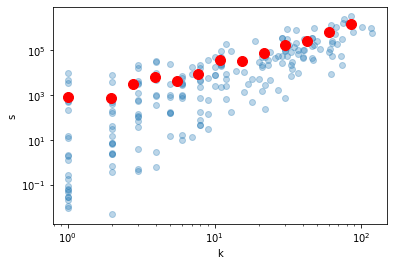

In [48]:
# Réseau d'échange de bananes (degrés totaux)
plt.loglog(kB,sB,'o',alpha=0.3)
logBins=np.logspace(np.log2(np.min(kB)),np.log2(np.max(kB)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(kB,sB,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10, color="red")
plt.xlabel('k')
plt.ylabel('s')
plt.show()

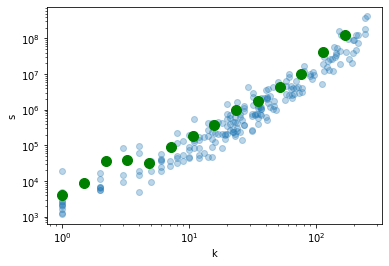

In [49]:
# Réseau d'échange de voitures (degrés totaux)
plt.loglog(kV,sV,'o',alpha=0.3)
logBins=np.logspace(np.log2(np.min(kV)),np.log2(np.max(kV)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(kV,sV,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10, color="green")
plt.xlabel('k')
plt.ylabel('s')
plt.show()

Dans les deux réseaux, la force des noeuds grandit avec le degré, surtout pour le réseau de commerce de voitures.  Cela semble logique : les pays qui ont des échanges commerciaux dans le monde entier sont souvent ceux qui échangent le plus. 

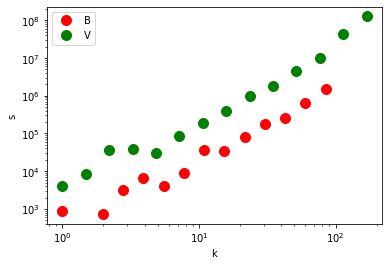

In [50]:
# Les deux réseaux (degrés totaux)
logBins=np.logspace(np.log2(np.min(kB)),np.log2(np.max(kB)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(kB,sB,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10, color="red", label="B")
logBins=np.logspace(np.log2(np.min(kV)),np.log2(np.max(kV)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(kV,sV,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10, color="green", label="V")
plt.xlabel('k')
plt.ylabel('s')
plt.legend()
plt.show()

On peut regarder la même chose sur les in et out degrees et strength, et on obtient cette même relation de corrélation positive. 

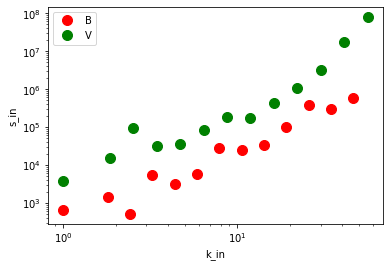

In [51]:
# Les deux réseaux (in-degrees)
logBins=np.logspace(np.log2(np.min(kB_in)),np.log2(np.max(kB_in)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(kB_in,sB_in,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10, color="red", label="B")
logBins=np.logspace(np.log2(np.min(kV_in)),np.log2(np.max(kV_in)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(kV_in,sV_in,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10, color="green", label="V")
plt.xlabel('k_in')
plt.ylabel('s_in')
plt.legend()
plt.show()

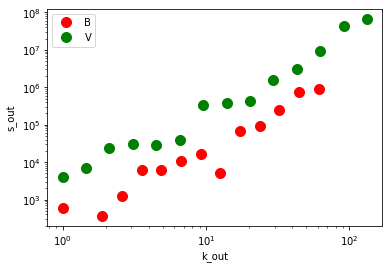

In [52]:
# Les deux réseaux (out-degrees)
logBins=np.logspace(np.log2(np.min(kB_out)),np.log2(np.max(kB_out)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(kB_out,sB_out,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10, color="red", label="B")
logBins=np.logspace(np.log2(np.min(kV_out)),np.log2(np.max(kV_out)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(kV_out,sV_out,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10, color="green", label="V")
plt.xlabel('k_out')
plt.ylabel('s_out')
plt.legend()
plt.show()

<mark> Par la suite, par simplicité de l'analyse, nous mettons de côté les degrés et forces in et out.</mark>

On cherche désormais à faire un fit pour observer si on a une relation linéaire.

In [53]:
def powerLaw(x, a, b):
    return b*x**(a)

1.966441451979321


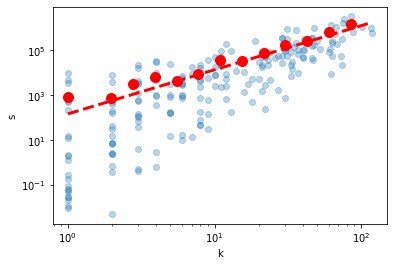

In [54]:
## Bananes
plt.loglog(kB,sB,'o',alpha=0.3)

#visualisation des données
logBins=np.logspace(np.log2(np.min(kB)),np.log2(np.max(kB)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(kB,sB,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10, color="red", label="B")


#on fait le fit jusqu'à k=50 pour être sûr que ça marche bien 
fitx=[i for (i,j) in zip(kB,sB) if  i<50] #k jusqu'à 50
fity=[j for (i,j) in zip(kB,sB) if i<50]
popt, pcov = curve_fit(powerLaw, fitx, fity)  
#popt, pcov = curve_fit(powerLaw, k, s)  
print (popt[0])
plt.loglog(sorted(kB), powerLaw(sorted(kB), *popt), '--',linewidth=3, color="red")

plt.xlabel('k')
plt.ylabel('s')
plt.show()

1.856741108225085


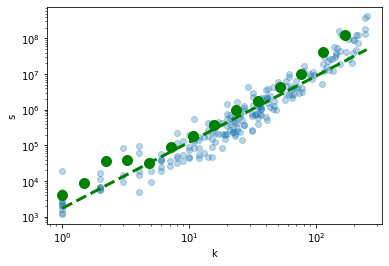

In [55]:
## Voitures
plt.loglog(kV,sV,'o',alpha=0.3)

#visualisation des données
logBins=np.logspace(np.log2(np.min(kV)),np.log2(np.max(kV)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(kV,sV,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10, color="green", label="V")


#on fait le fit jusqu'à k=50 pour être sûr que ça marche bien 
fitx=[i for (i,j) in zip(kV,sV) if  i<50] #k jusqu'à 50
fity=[j for (i,j) in zip(kV,sV) if i<50]
popt, pcov = curve_fit(powerLaw, fitx, fity)  
#popt, pcov = curve_fit(powerLaw, k, s)  
print (popt[0])
plt.loglog(sorted(kV), powerLaw(sorted(kV), *popt), '--',linewidth=3, color="green")

plt.xlabel('k')
plt.ylabel('s')
plt.show()

La relation semble être relativement linéaire. Les pays qui ont respectivement des bananes et des voitures vont, en toute logique, en vendre plus que les autres. La pondération est dans ce cas associée à la structure topologique pour les deux réseaux. 

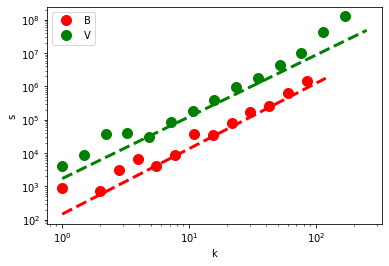

In [56]:
## Les deux réseaux superposés

#Bananes
logBins=np.logspace(np.log2(np.min(kB)),np.log2(np.max(kB)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(kB,sB,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10, color="red", label="B")
fitx=[i for (i,j) in zip(kB,sB) if  i<50] #k jusqu'à 50
fity=[j for (i,j) in zip(kB,sB) if i<50]
popt, pcov = curve_fit(powerLaw, fitx, fity)  
plt.loglog(sorted(kB), powerLaw(sorted(kB), *popt), '--',linewidth=3, color="red")

# Voitures
logBins=np.logspace(np.log2(np.min(kV)),np.log2(np.max(kV)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(kV,sV,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10, color="green", label="V")
fitx=[i for (i,j) in zip(kV,sV) if  i<50] #k jusqu'à 50
fity=[j for (i,j) in zip(kV,sV) if i<50]
popt, pcov = curve_fit(powerLaw, fitx, fity)  
plt.loglog(sorted(kV), powerLaw(sorted(kV), *popt), '--',linewidth=3, color="green")

plt.xlabel('k')
plt.ylabel('s')
plt.legend()
plt.show()

## Robustness

On cherche ici à évaluer la robustesse du réseau.

### Random failures

On enlève (attaque) aléatoirement des noeuds. Je choisis la fraction que j'enlève 1/20 = 5/100 des noeuds.

In [57]:
fList=np.linspace(0,1,20)
NtoRemB=[int(i*GB.number_of_nodes()) for i in fList]
NtoRemV=[int(i*GV.number_of_nodes()) for i in fList]

In [58]:
print("GB", NtoRemB)
print("GV", NtoRemV)

GB [0, 10, 21, 32, 42, 53, 64, 74, 85, 96, 106, 117, 128, 138, 149, 160, 170, 181, 192, 203]
GV [0, 11, 22, 33, 44, 56, 67, 78, 89, 100, 112, 123, 134, 145, 156, 168, 179, 190, 201, 213]


In [59]:
def randomAttack(NtoRem,G):
    sf=[]
    for nn in NtoRem[:-1]:
        # je copie mon graphe pour ne pas toucher au graphe initial
        thisG=G.copy()
        # je prends un échantillon aléatoire de ces noeuds. 
        ll=random.sample(G.nodes(),nn)
        # je les enlève du graphe
        thisG.remove_nodes_from(ll)
        #je calcule la taille de la plus grande composante (maximale) parmi le graphe faiblement connecté
        thisSf=len(max(sorted(nx.weakly_connected_components(thisG), key = len, reverse=True))) #weakly new
        # j'ajoute la taille/nb noeud dans la liste sf. 
        sf.append(thisSf/float(G.number_of_nodes()))
    return(sf)

In [60]:
sfB = randomAttack(NtoRem=NtoRemB,G=GB)
sfV = randomAttack(NtoRem=NtoRemV,G=GV)

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """Entry point for launching an IPython kernel.
C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  


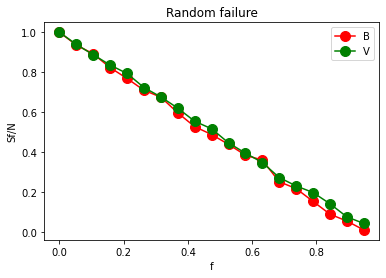

In [61]:
plt.plot(fList[:-1],sfB,'o-',markerSize=10, color="red", label="B")
plt.plot(fList[:-1],sfV,'o-',markerSize=10, color="green", label="V")
plt.xlabel('f')
plt.ylabel('Sf/N')
plt.title("Random failure")
plt.legend()
plt.show()

### attacks

Attaque ciblée dans laquelle j'enlève les noeuds **aux forces** les plus importants. 

In [62]:
# Bananes
hhB=collections.Counter(dict(GB.degree(weight='weight'))).most_common()
#je classe les noeuds selon leur degré.
orderedNodesB=[u for (u,v) in hhB]
#10 premiers noeuds
print(orderedNodesB[:10])

['Ecuador', 'USA', 'Costa Rica', 'Belgium', 'Philippines', 'Germany', 'Colombia', 'Netherlands', 'Guatemala', 'Japan']


In [63]:
# Voitures
hhV=collections.Counter(dict(GV.degree(weight='weight'))).most_common()
#je classe les noeuds selon leur degré.
orderedNodesV=[u for (u,v) in hhV]
#10 premiers noeuds
print(orderedNodesV[:10])

['USA', 'Germany', 'Japan', 'Mexico', 'China', 'United Kingdom', 'France', 'Canada', 'Spain', 'Italy']


In [64]:
fList1=np.linspace(0,1,20)
NtoRemB=[int(i*GB.number_of_nodes()) for i in fList1]
NtoRemV=[int(i*GV.number_of_nodes()) for i in fList1]

In [65]:
def focusAttack(NtoRem,G, orderedNodes):
    sfAtt=[]
    for nn in NtoRem[:-1]:
        thisG=G.copy()
        # je prends les nn premiers dans le classement
        ll=orderedNodes[:nn]
        # je les enlève
        thisG.remove_nodes_from(ll)
        # je calcule la composante faiblement connectée
        thisSf=len(max(sorted(nx.weakly_connected_components(thisG), key = len, reverse=True))) #weakly new
        sfAtt.append(thisSf/float(G.number_of_nodes()))
    return(sfAtt)

In [66]:
sfAttB = focusAttack(NtoRem=NtoRemB,G=GB, orderedNodes=orderedNodesB)
sfAttV = focusAttack(NtoRem=NtoRemV,G=GV, orderedNodes=orderedNodesV)

Les attaques ciblées sont plus efficaces que les attaques random car on se retrouve sur un réseau déconnecté. 

**Les attaques ciblées sur la FORCE des noeuds sont plus efficaces dans le réseau des voitures que dans celui des bananes.**


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """Entry point for launching an IPython kernel.
C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  
C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  after removing the cwd from sys

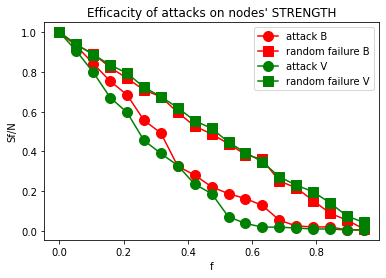

In [67]:
plt.plot(fList1[:-1],sfAttB,'o-',markerSize=10,label='attack B', color="red")
plt.plot(fList[:-1],sfB,'s-',markerSize=10,label='random failure B', color="red")
plt.plot(fList1[:-1],sfAttV,'o-',markerSize=10,label='attack V', color="green")
plt.plot(fList[:-1],sfV,'s-',markerSize=10,label='random failure V', color="green")
plt.xlabel('f')
plt.ylabel('Sf/N')
plt.title("Efficacity of attacks on nodes' STRENGTH")
plt.legend()
plt.show()

Si on attaque cette fois-ci selon le DEGRE et non la FORCE des noeuds le résultat est inversé !

**Les attaques ciblées sur le DEGRE des noeuds sont plus efficaces dans le réseau des bananes que dans celui des voitures.**


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  
C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if __name__ == '__main__':
C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # This is added back by InteractiveShellApp.init_path()


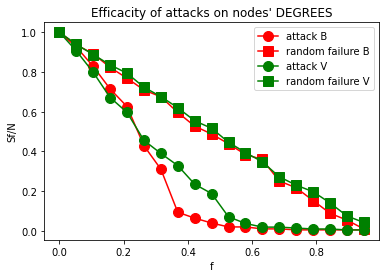

In [68]:
hhB_deg=collections.Counter(dict(GB.degree())).most_common()
orderedNodesB_deg=[u for (u,v) in hhB_deg]
hhV_deg=collections.Counter(dict(GV.degree())).most_common()
orderedNodesV_deg=[u for (u,v) in hhV]
sfAttB_deg= focusAttack(NtoRem=NtoRemB,G=GB, orderedNodes=orderedNodesB_deg)
sfAttV_deg = focusAttack(NtoRem=NtoRemV,G=GV, orderedNodes=orderedNodesV_deg)

plt.plot(fList1[:-1],sfAttB_deg,'o-',markerSize=10,label='attack B', color="red")
plt.plot(fList[:-1],sfB,'s-',markerSize=10,label='random failure B', color="red")
plt.plot(fList1[:-1],sfAttV_deg,'o-',markerSize=10,label='attack V', color="green")
plt.plot(fList[:-1],sfV,'s-',markerSize=10,label='random failure V', color="green")
plt.xlabel('f')
plt.ylabel('Sf/N')
plt.title("Efficacity of attacks on nodes' DEGREES")
plt.legend()
plt.show()

# 3. Spectrum of (un)weighted clustering coefficient [FACULTATIF]

Si les exercices 1 et 2 sont trop simples ! 
Regarder la définition de « weighted clustering coefficient » dans le papier :

[Barrat, A., Barthelemy, M., Pastor-Satorras, R., & Vespignani, A. (2004). The architecture of complex weighted networks. Proceedings of the national academy of sciences, 101(11), 3747-3752).](https://www.pnas.org/content/pnas/101/11/3747.full.pdf)

Calculer le **spectrum du clustering pondéré et non pondéré** pour le réseau du commerce de voitures. 


## Formule de l'article de Barrat et al.

Le calcul d'un clustering coefficient pondéré proposé dans *Barrat .et al* (2004) est le suivant : 

$$
\widetilde C_{i,B} = \frac{1}{s_i(k_i-1)}\sum_{j,h} \frac{w_{ij} + w_{ih}}{2} a_{ij} a_{jh} a_{ih}
$$

Avec : 
- $k_i$ le degré du noeud $i$
- $s_i$ la force d'un noeud $i$ 
- $w_{ij}$ le poids associé au lien de i vers j
- $a_{ij}=1$ s'il y a une arête entre $i$ et $j$ et 0 sinon.


## Application 

Chargement des données comme précédemment

In [70]:
dfV=pd.read_csv('data/vehiclesDB.csv',sep=',')
dfV = dfV.rename(columns={'v': 'weight'})
dfV.head()
GV=nx.from_pandas_edgelist(dfV,'exp','imp',['weight'],create_using=nx.DiGraph())
#sB=list(dict(GB.degree(weight='weight')).values())
#kB=list(dict(GB.degree()).values())

Fonction qui permet de lister l'ensemble des voisins d'un noeud i.

In [126]:
def get_neighbors(G, i):
    predecessors = list(G.predecessors(i))
    successors = list(G.successors(i))
    neighbors = list(dict.fromkeys(predecessors + successors)) #remove duplicate nodes
    return(neighbors)

#Example neigbors of node Albania)
print(get_neighbors(GV, 'Albania'))

['France', 'Greece', 'Italy', 'Spain', 'Belgium', 'Canada', 'Czechia', 'Germany', 'Japan', 'Sweden', 'USA', 'China', 'United Arab Emirates', 'Netherlands', 'Rep. of Korea', 'Switzerland', 'United Kingdom', 'Bulgaria', 'Hungary', 'Serbia', 'Slovakia', 'Slovenia', 'Turkey', 'Senegal']


Fonction de calcul du *weighted clustering coefficient*.

In [140]:
def weighted_clustering_coefficient(G, i):
    k_i = G.degree(i)
    s_i = G.degree(i, weight = "weight")
    weighted_sum = 0
    for j in get_neighbors(G, i):
        aij = j in list(G[i])
        for h in get_neighbors(G, i) :
            ajh = h in list(G[j])
            aih = h in list(G[i])
            if ajh and aih and aij and j!=h:
                weighted_sum = weighted_sum + (G[i][j]['weight']+G[i][h]['weight'])/2
    if k_i > 1:
         wcc = (1/(s_i*(k_i-1))) * weighted_sum
    else: 
         wcc = 0
    return(wcc)  

#Example clustering coefficient of Albania
print(weighted_clustering_coefficient(GV, 'Albania'))

0.006328054249271999


In [138]:
k=[GV.degree(u) for u in GV.nodes()]
c=[nx.clustering(GV,u) for u in GV.nodes()]
c_w = [weighted_clustering_coefficient(GV, node) for node in GV.nodes() ]
print(min(c_w))
print(max(c_w))

0.0
0.38303177237113717


Le coefficient pondéré diffère sensiblement du coefficient pondéré. 

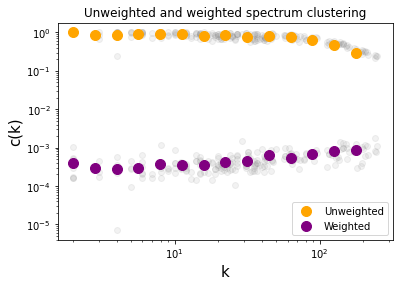

In [143]:
# Unweighted
xx=[u for (u,v) in zip(k,c) if v>0]
yy=[v for (u,v) in zip(k,c) if v>0]
plt.loglog(xx,yy,'o',alpha=0.1, color="grey") # On plot tous les points
lo=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
ybin1,xbin1,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=lo)

#Weighted
xx=[u for (u,v) in zip(k,c_w) if v>0]
yy=[v for (u,v) in zip(k,c_w) if v>0]
plt.loglog(xx,yy,'o',alpha=0.1, color="grey") # On plot tous les points
lo=np.logspace(np.log2(np.min(xx)),np.log2(np.max(xx)),base=2,num=15)
# On fait une somme par classes de degrés échelle logarithmique
ybin2,xbin2,binnumber=scipy.stats.binned_statistic(xx,yy,statistic='mean',bins=lo)

#Plot both
plt.loglog(xbin1[:-1],ybin1,'o',label='Unweighted',markersize=10, color="orange")
plt.loglog(xbin2[:-1],ybin2,'o',label='Weighted',markersize=10, color="purple")
plt.xlabel('k',size=15)
plt.ylabel('c(k)',size=15)
plt.legend()
plt.title("Unweighted and weighted spectrum clustering")
plt.show()